In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from matplotlib import cm
from scipy.integrate import dblquad
import numpy as np
from tqdm import tqdm
import scipy.stats
import os
from importlib import reload

import nigiwai_random
reload(nigiwai_random)

<module 'nigiwai_random' from '/Users/kaji/Dropbox/maple/COI/Nigiwai_vectorfields/Nigiwai_Randomness/kaji/nigiwai_random.py'>

In [97]:
# Consgestion data
scale = 1
start_frame = 0
end_frame = 300
frame_skip = 1

#datadir = "../data/500fr_ratio_test"
datadir = "../data/300fr_spawn"

# shopping ratio test data
names = sorted(os.listdir(datadir))
df_list = [pd.read_csv(os.path.join(datadir,fn),header=0,delim_whitespace=True,dtype='f8') for fn in names]
names = [os.path.splitext(fn)[0] for fn in names]

coords = [nigiwai_random.load_vadere(df, scale, start_frame, end_frame, frame_skip) for df in df_list]


100%|██████████| 112059/112059 [00:04<00:00, 27583.90it/s]


# Nigiwai indicator

In [104]:
# parameters for indicators
fr_number = 9 # time window for computing Nigiwai
weight_r1_each = 0 # weight of R_1 in Nigiwai for individual pedestrians
weight_r1_all = 1 # weight of R_1 in Nigiwai for all pedestrians
weight_all = 0.5 # weight of Nigiwai for all pedestrians
weight_entropy = 0.5 # weight of entropy
noise_std = 0 # std of gaussian noise for the coordinate

In [105]:
indicator_list_graph = []
# Data process
for df_vadere in tqdm(coords):    
    X, Y = nigiwai_random.add_noise_to_coords(df_vadere[0],df_vadere[1],noise_std)
    u, v = nigiwai_random.compute_velocity(X,Y,noise_std)
    
    # iterate over frames
    indicator_list = []
    for target_fr in range(fr_number, round(end_frame/frame_skip)-1):
        u_f = u[:,target_fr-fr_number:target_fr+1]
        v_f = v[:,target_fr-fr_number:target_fr+1]

        ped_mask = ~np.isnan( (u_f.sum(axis=1)+v_f.sum(axis=1)) )
        u_f = u_f[ped_mask]
        v_f = v_f[ped_mask]

        all_mask = ~np.isnan( u[:,target_fr]+v[:,target_fr] )
        u_g = u[all_mask,target_fr].reshape(1,-1)
        v_g = v[all_mask,target_fr].reshape(1,-1)        
        
        # indicators
        r1_each = nigiwai_random.compute_moment(u_f,v_f,1)
        r2_each = nigiwai_random.compute_moment(u_f,v_f,2)
        r1_all = nigiwai_random.compute_moment(u_g,v_g,1)
        r2_all = nigiwai_random.compute_moment(u_g,v_g,2)

        # aggregated indicators
        indicator_f = np.maximum(1 - (weight_r1_each*r1_each + (1-weight_r1_each)*r2_each),0)
        indicator_g = np.maximum(1 - (weight_r1_all*r1_all   + (1-weight_r1_all)*r2_all),0)
        indicator_ent =  nigiwai_random.entropy_base(u_f,v_f)

        indicator_each_ped = (indicator_ent ** weight_entropy) * (indicator_f** (1-weight_entropy))
        if len(indicator_each_ped)>0:
            indicator_each_ped_mean = indicator_each_ped.mean()
        else:
            indicator_each_ped_mean = 0

        indicator = (indicator_g**weight_all) * ( indicator_each_ped_mean **(1-weight_all))
        
        indicator_list.append(indicator) # generate list of indicators


    # moving average for indicator graph
    indicator_list_graph.append(nigiwai_random.moving_average(indicator_list, alpha=0.8))


100%|██████████| 2/2 [00:00<00:00,  8.04it/s]


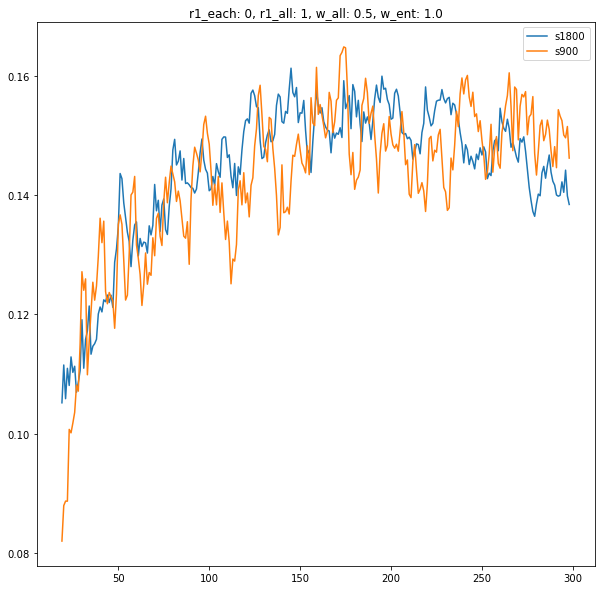

In [106]:
plt.figure(figsize=(10, 10))
plt.title(f'r1_each: {weight_r1_each}, r1_all: {weight_r1_all}, w_all: {weight_all}, w_ent: {weight_entropy}')
st = 10
x_values = list(range(fr_number+st, round(end_frame/frame_skip)-1))
for i in range(len(indicator_list_graph)):
    plt.plot(x_values, indicator_list_graph[i][st:], label=names[i])
#plt.axis([fr_number+5, round(end_frame/frame_skip)-1, 0.1, 0.6])
plt.legend()
plt.show()